In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from skimage.metrics import structural_similarity as ssim_skimage

#### The following code uses UMBMID - gen 2 files...

### Data pre-processing

In [2]:
def load(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)
    
def data(complete_ds, metadata_complete, clean, metadata_clean):

    """
    Load complete and skin-suppressed pickle files, then create a filtered version
    of the complete dataset (without any substraction) that matches the skin-suppressed sample IDs.
    
    Parameters:
    -----------
    complete_ds : str
        Path to the complete dataset pickle file. Shape: (1301, 1001, 72)
    metadata_complete : str
        Path to the complete metadata pickle file
    clean : str
        Path to the skin-suppressed dataset pickle file. Shape: (505, 1001, 72)
    metadata_clean : str
        Path to the skin-suppressed metadata pickle file
        
    Returns:
    --------
    3 datasets
        - without_skin: Skin-suppressed dataset array
        - with_skin: Filtered complete dataset matching suppressed sample IDs
        - metadata_without_skin: Skin-suppressed metadata file 
    """
       
    complete = load(complete_ds)
    without_skin = load(clean)
    metadata_complete = load(metadata_complete)
    metadata_without_skin = load(metadata_clean)

    #get ID and indexes of every sample in the skinsupressed data - then filter the complete dataset to pair
    ids_metadata_wos = set([i.get('id') for i in metadata_without_skin])
    indexes = [i for i, sample in enumerate(metadata_complete) if sample.get('id') in ids_metadata_wos]

    with_skin = complete[indexes]

    return without_skin, with_skin, metadata_without_skin

without_skin, with_skin, metadata_wos = data("fd_data_gen_two_s11.pickle", "metadata_gen_two.pickle",
                                             "fd_data_s11_adi.pickle", "md_list_s11_adi.pickle") 


In [ ]:
print(metadata_wos[494])
# 90/7: ('phant_id'): 'A11F1', np.str_('tum_rad'): 1.5, np.str_('tum_shape'): 'sphere', np.str_('tum_x'): 2.25, np.str_('tum_y'): -2.25, ('ant_rad'): 22.0
# 46/24: 'phant_id'): 'A16F13', np.str_('tum_rad'): 1.0, np.str_('tum_shape'): 'sphere', np.str_('tum_x'): -0.75, np.str_('tum_y'): -0.75, ('ant_rad'): 23.0
# 494/41: 'phant_id'): 'A3F3', np.str_('tum_rad'): 1.5, np.str_('tum_shape'): 'sphere', np.str_('tum_x'): -2.25, np.str_('tum_y'): -1.0, ('ant_rad'): 22.0
#140/42:  1.5, np.str_('tum_shape'): 'sphere', np.str_('tum_x'): -0.75, np.str_('tum_y'): 3.75
#76/35: 1.5, np.str_('tum_shape'): 'sphere', np.str_('tum_x'): -2.25, np.str_('tum_y'): 2.25
#210/33: 1.5, np.str_('tum_shape'): 'sphere', np.str_('tum_x'): 1.25, np.str_('tum_y'): -0.75

{np.str_('n_expt'): 1, np.str_('id'): 1276, np.str_('phant_id'): 'A3F3', np.str_('tum_rad'): 1.5, np.str_('tum_shape'): 'sphere', np.str_('tum_x'): -2.25, np.str_('tum_y'): -1.0, np.str_('tum_z'): -6.5, np.str_('birads'): 2, np.str_('adi_ref_id'): 1279, np.str_('emp_ref_id'): 1280, np.str_('date'): '2019-12-13', np.str_('n_session'): 150, np.str_('ant_rad'): 22.0, np.str_('ant_z'): -6.51, np.str_('fib_ang'): 180.0, np.str_('adi_x'): 0.0, np.str_('adi_y'): 0.0, np.str_('fib_ref_id'): nan, np.str_('fib_x'): 0.0, np.str_('fib_y'): 0.0, np.str_('tum_in_fib'): 0}


In [3]:
# Compute the phase (angle) from the complex-valued input data
pha_ws = np.angle(with_skin)  # Phase of skin-suppressed data
pha_wos = np.angle(without_skin)    # Phase of complete data (with skin)

# Compute the magnitude (absolute value) from the complex-valued input data
mag_ws = np.abs(with_skin)       # Magnitude of complete data (with skin)
mag_wos = np.abs(without_skin)   # Magnitude of skin-suppressed data


# --- Frequency Selection and Downsampling ---

# Remove the first 139 frequency points to restrict the frequency range to 2–8 GHz (original range is 1–8 GHz)
# Then, downsample the data by selecting every 3rd frequency step to reduce input size and speed up training

o_pha_wos_s = pha_wos[:, 139::3, :]
o_pha_ws_s = pha_ws[:, 139::3, :]
mag_wos_s = mag_wos[:, 139::3, :]
mag_ws_s = mag_ws[:, 139::3, :]

### U-Net

In [ ]:
def build_unet(input_shape=(288, 72, 1), mode='phase'):
    """
    Builds a U-Net model for phase or magnitude data.
    
    Parameters:
    -----------
    input_shape : tuple
        Shape of the input tensor (height, width, channels)
    mode : str
        Type of data to process. Either 'phase' or 'magnitude'.
        
    Returns:
    --------
    model : keras.Model
        Compiled U-Net model
    """
    
    assert mode in ['phase', 'magnitude'], "mode must be 'phase' or 'magnitude'"
    
    inputs = Input(input_shape)

    # Encoder
    def conv_block(x, filters, dropout_rate):
        x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        return x

    c1 = conv_block(inputs, 32, 0.1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 64, 0.1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 128, 0.1)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    # Decoder
    def up_block(x, skip, filters, dropout_rate):
        x = UpSampling2D((2, 2))(x)
        x = concatenate([x, skip])
        x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        return x

    c5 = up_block(c4, c3, 128, 0.1)
    c6 = up_block(c5, c2, 64, 0.1)
    c7 = up_block(c6, c1, 32, 0.1)

    # Output layer (customized per mode)
    pre_output = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    pre_output = BatchNormalization()(pre_output)

    def phase_clip(x):
        """Función para asegurar que la salida esté en [-π, π]"""
        return tf.clip_by_value(x, -np.pi, np.pi)

    if mode == 'phase':
        pre_output = Conv2D(1, (1, 1), activation='linear',
                            kernel_initializer=tf.keras.initializers.RandomUniform(-0.1, 0.1))(pre_output)
        outputs = Lambda(phase_clip)(pre_output)
    else:  # magnitude
        outputs = Conv2D(1, (1, 1), activation=None, kernel_initializer='glorot_uniform')(pre_output)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
def build_unet(input_shape=(200, 72, 1), mode='phase'):
    assert mode in ['phase', 'magnitude'], "mode must be 'phase' or 'magnitude'"
    inputs = Input(input_shape)
    
    # Encoder (Downsampling)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    
    # Decoder (Upsampling)
    u4 = UpSampling2D((2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    pre_output = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    # Capa de salida
    if mode == 'phase':
        pre_output = Conv2D(1, (1, 1), activation='linear',
                            kernel_initializer=tf.keras.initializers.RandomUniform(-0.1, 0.1))(pre_output)
        
    else:  # magnitude
        outputs = Conv2D(1, (1, 1), activation=None, kernel_initializer='glorot_uniform')(pre_output)
    
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

### Phase
##### This section handles the splitting of phase data into training, validation, and test sets. Defines specific loss functions used for training and evaluates its performance.

In [5]:
# === Phase Data: Input Preparation and Train/Val/Test Splitting ===

# Expand the last dimension to add a channel axis (required by CNN input format)
# X: input data with skin (e.g., containing surface reflections)
# y: target data without skin (e.g., surface reflections removed)
X = np.expand_dims(o_pha_ws_s, axis=-1)  # Shape: (samples, freq, antennas, 1)
y = np.expand_dims(o_pha_wos_s, axis=-1)

# ---- Step 1: Split into Training (80%) and Temp (20%) ----
# We'll reserve 20% of the data to later split into validation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---- Step 2: Split Temp into Validation (10%) and Test (10%) ----
# The temporary set is evenly split to form validation and test sets (10% each of the full dataset)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# ---- (Optional) Track Original Indices for Evaluation or Debugging ----
# This helps in tracing model predictions back to original samples
indices_original = np.arange(len(X))

# Get original indices for each dataset split
indices_train, indices_temp = train_test_split(
    indices_original, test_size=0.2, random_state=42
)
indices_val, indices_test = train_test_split(
    indices_temp, test_size=0.5, random_state=42
)

# ---- Summary of Dataset Shapes ----
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print("Test indices:", indices_test)


Train: (404, 288, 72, 1), Val: (50, 288, 72, 1), Test: (51, 288, 72, 1)
Test indices: [311 484 394  82 299  73  30  90 218 173 195 172 411 358 203 305 502 380
 480 453 104 137  79 204  46 312 495 314 499 331   9 336 410 210 391  76
  70 101 153 124 407 494 140  68 354 318 447 364 444 229   0]


In [6]:
# === Custom Loss Functions and Metrics for Phase Data ===

def combined_loss(y_true, y_pred):
    """
    Combined custom loss function for phase regression.

    This loss blends:
    - Circular MSE (main component) to handle periodicity
    - SSIM (Structural Similarity Index) to preserve spatial structures
    - Circular MAE as an auxiliary error term

    Final loss = 0.8 * circular_MSE + 0.1 * SSIM + 0.1 * circular_MAE

    Returns:
        Tensor: Weighted sum of losses.
    """
    ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

    diff = y_true - y_pred
    diff = tf.atan2(tf.sin(diff), tf.cos(diff))  # Normalize difference to [-π, π]

    circ_mse = tf.reduce_mean(tf.square(diff))
    circ_mae = tf.reduce_mean(tf.abs(diff))

    #return 0.8 * circ_mse + 0.1 * ssim + 0.1 * circ_mae
    return 0.9 * circ_mse + 0.1 * circ_mae


# === Build and Compile Phase Model ===

model_phase = build_unet(input_shape=(288, 72, 1), mode='phase')

# Compile the model using the combined loss
model_phase.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=combined_loss
)

# model_phase.summary()  # Uncomment if you want to inspect the architecture

# === Train the Phase Model ===

history_phase = model_phase.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Use validation set to monitor generalization
    epochs=50,
    batch_size=8
)

# === Plot Training and Validation Loss ===

# Extract training history (assuming model.fit() has been run previously)
loss = history_phase.history['loss']         # Training loss over epochs
val_loss = history_phase.history['val_loss'] # Validation loss over epochs
epochs = range(1, len(loss) + 1)


plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs, val_loss, 'r-', label='Validation Loss', linewidth=2)


plt.title('Evolution of Loss Function Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()


plt.show()


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 46s 782ms/step - loss: 2.8047 - val_loss: 2.9425
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 733ms/step - loss: 2.2568 - val_loss: 2.4568
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 824ms/step - loss: 2.0352 - val_loss: 2.0906
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 829ms/step - loss: 1.8963 - val_loss: 1.9944
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 44s 866ms/step - loss: 1.8147 - val_loss: 1.8576
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 38s 741ms/step - loss: 1.7284 - val_loss: 1.8443
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 36s 706ms/step - loss: 1.6674 - val_loss: 1.7875
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 39s 773ms/step - loss: 1.6233 - val_loss: 1.6455
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 38s 745ms/step - loss: 1.5748 - val_loss: 1.6419
Epoch 10/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 735ms/step - loss: 1.5224 - val_loss: 1.7168
Epoch 11/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 38s 753ms/step - loss: 1.4981 - val_loss: 1.5911
Epoch 12/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 462ms/step
Visualizing test sample 41 (original index: 494)


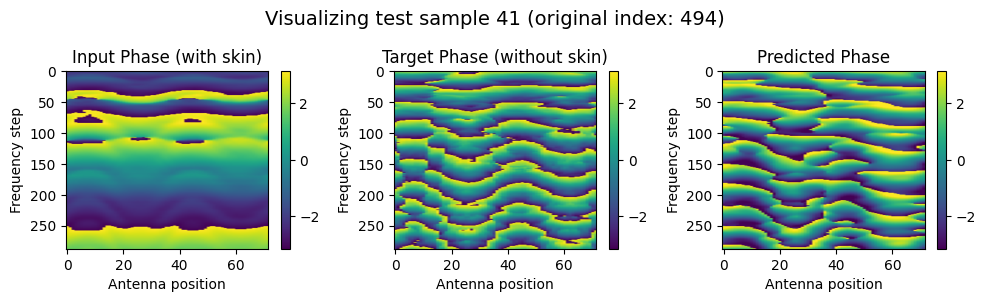

Phase:
Circular MSE: 1.384119
Circular MAE: 0.895367
Correlation: 0.522026


In [71]:
# === Phase Prediction, Visualization, and Circular Metrics Evaluation ===

# Predict on the test set
predicted_phase = model_phase.predict(X_test)  # Output shape: (samples, freq, antennas, 1)

# Select a specific test sample to visualize
idx = 41
print(f"Visualizing test sample {idx} (original index: {indices_test[idx]})")

# --- Create visualization for input, target, and prediction ---
plt.figure(figsize=(10, 5))
plt.suptitle(f"Visualizing test sample {idx} (original index: {indices_test[idx]})", fontsize=14)


# Input phase with skin
plt.subplot(2, 3, 1)
plt.title("Input Phase (with skin)")
plt.xlabel('Antenna position')
plt.ylabel('Frequency step')
im1 = plt.imshow(X_test[idx], cmap='viridis', aspect='auto')
plt.colorbar(im1)

# Ground-truth (target) phase without skin
plt.subplot(2, 3, 2)
plt.title("Target Phase (without skin)")
plt.xlabel('Antenna position')
plt.ylabel('Frequency step')
im2 = plt.imshow(y_test[idx], cmap='viridis', aspect='auto')
plt.colorbar(im2)

# Predicted phase from U-Net model
plt.subplot(2, 3, 3)
plt.title("Predicted Phase")
plt.xlabel('Antenna position')
plt.ylabel('Frequency step')
im3 = plt.imshow(predicted_phase[idx], cmap='viridis', aspect='auto')
plt.colorbar(im3)

plt.tight_layout()
plt.show()



def circular_correlation(true_phase, pred_phase):
    """
    Calculates the circular correlation between true and predicted phase values.

    This method is based on the projection of both true and predicted phase values onto 
    their sine and cosine components. It computes a correlation value between the two 
    phase signals in a way that accounts for the circular nature of phase data (i.e., 
    the periodicity of angles).

    Parameters:
    - true_phase (numpy.ndarray): The true phase values (in radians).
    - pred_phase (numpy.ndarray): The predicted phase values (in radians).

    Returns:
    - float: The correlation coefficient between the true and predicted phases, based on 
      their sine and cosine projections.
    """
    # Compute the sine and cosine of the true and predicted phases
    sin_true = np.sin(true_phase)
    cos_true = np.cos(true_phase)
    sin_pred = np.sin(pred_phase)
    cos_pred = np.cos(pred_phase)

    # Compute the numerator of the circular correlation
    num = np.mean(sin_true * sin_pred + cos_true * cos_pred)

    # Compute the denominator of the circular correlation
    den = np.sqrt(np.mean(sin_true**2 + cos_true**2) * np.mean(sin_pred**2 + cos_pred**2))

    # Return the final circular correlation
    return num / den



def calculate_circular_metrics(true_phase, pred_phase):
    """
    Calculates circular error metrics between true and predicted phase values.

    This function computes three key metrics to evaluate the accuracy of phase predictions:
    - Circular Mean Squared Error (MSE): Measures the squared angular difference between 
      true and predicted phases, adjusted to the circular domain.
    - Circular Mean Absolute Error (MAE): Measures the absolute angular difference between 
      true and predicted phases, adjusted to the circular domain.
    - Circular Correlation: Measures the correlation between the true and predicted phase 
      values, accounting for phase periodicity.

    Parameters:
    - true_phase (numpy.ndarray): The true phase values (in radians).
    - pred_phase (numpy.ndarray): The predicted phase values (in radians).

    Returns:
    - dict: A dictionary containing the following metrics:
        - 'Circular MSE': Mean squared error between true and predicted phases.
        - 'Circular MAE': Mean absolute error between true and predicted phases.
        - 'Correlation': Circular correlation between true and predicted phases.
    """
    # Calculate the angular difference between true and predicted phases in the circular domain [-π, π]
    diff = np.angle(np.exp(1j * (true_phase - pred_phase)))
    
    # Calculate Circular Mean Squared Error (MSE)
    mse = np.mean(diff ** 2)

    # Calculate Circular Mean Absolute Error (MAE)
    mae = np.mean(np.abs(diff))
    
    # Calculate the correlation coefficient between the true and predicted phases
    correlation = np.corrcoef(true_phase.flatten(), pred_phase.flatten())[0, 1]
    
    # Calculate the circular correlation using the defined method
    correlation1 = circular_correlation(true_phase, pred_phase)

    # Return the calculated metrics as a dictionary
    return {
        'Circular MSE': mse,
        'Circular MAE': mae,
        'Correlation': correlation1
    }

# Example of evaluating phase metrics
print("Phase:")
# Calculate and print circular metrics for the true and predicted phase values
phase_metrics_ = calculate_circular_metrics(y_test, predicted_phase)
for metric, value in phase_metrics_.items():
    print(f"{metric}: {value:.6f}")

### Magnitude
##### This section handles the normalization of magnitude data, splitting into training, validation, and test sets. Defines combined loss function used for training and evaluates its performance.

In [9]:
def normalize_complex_data_with_percentiles(magnitude_data, lower_percentile=0.0, upper_percentile=100):
    """
    Normalize each sample of magnitude data independently using percentile-based scaling.

    This method rescales the data such that:
        - The `lower_percentile` becomes 0
        - The `upper_percentile` becomes 1
        - All values are clipped to [0, 1] range

    Parameters:
    -----------
    magnitude_data : np.ndarray
        Array of shape (N, F, A) where N = samples, F = frequency steps, A = antenna positions.
    lower_percentile : float
        Lower percentile used for normalization (default: 0.0).
    upper_percentile : float
        Upper percentile used for normalization (default: 100.0).

    Returns:
    --------
    mag_normalized : np.ndarray
        Normalized magnitude data in [0, 1], same shape as input.
    percentiles_mag : list of tuples
        List containing (lower, upper) percentile values for each sample,
        required for later denormalization.
    """
    mag_normalized = np.zeros_like(magnitude_data)
    percentiles_mag = []

    for i in range(magnitude_data.shape[0]):
        mag_sample = magnitude_data[i]

        # Compute percentiles for current sample
        mag_p_lower = np.percentile(mag_sample, lower_percentile)
        mag_p_upper = np.percentile(mag_sample, upper_percentile)

        # Normalize and clip to [0, 1]
        mag_normalized_sample = (mag_sample - mag_p_lower) / (mag_p_upper - mag_p_lower)
        mag_normalized_sample = np.clip(mag_normalized_sample, 0, 1)

        mag_normalized[i] = mag_normalized_sample
        percentiles_mag.append((mag_p_lower, mag_p_upper))

    return mag_normalized, percentiles_mag


def denormalize(normalized_magnitude, percentiles_mag, indices):
    """
    Denormalize a batch of normalized magnitude data using the original percentiles.

    Parameters:
    -----------
    normalized_magnitude : np.ndarray
        Normalized data in [0, 1], shape: (N, F, A).
    percentiles_mag : list of tuples
        List containing (lower, upper) percentile values for each original sample.
    indices : list or np.ndarray
        Indices pointing to which original sample each row of `normalized_magnitude` comes from.
        This is typically used after splitting the dataset (e.g. for test/validation).

    Returns:
    --------
    mag_denorm : np.ndarray
        Denormalized magnitude data with original scale restored.
    """
    mag_denorm = np.zeros_like(normalized_magnitude)

    for i in range(normalized_magnitude.shape[0]):
        original_idx = indices[i]
        mag_p_lower, mag_p_upper = percentiles_mag[original_idx]

        # Revert normalization
        mag_denorm[i] = normalized_magnitude[i] * (mag_p_upper - mag_p_lower) + mag_p_lower

    return mag_denorm

# Normalize magnitude data with skin (mag_ws_s)
mag_ws_normalized_, percentiles_ws_mag_ = normalize_complex_data_with_percentiles(mag_ws_s)

# Scale target magnitudes to avoid very small values (~0.003) that weaken MSE gradients.
# This improves training stability and prediction accuracy.
mag_wos_scaled_100 = mag_wos_s*100

In [10]:
# Expand dimensions to match the expected input shape for CNNs (add channel dimension).
Xm = np.expand_dims(mag_ws_normalized_, axis=-1)   # Input data: with skin
ym = np.expand_dims(mag_wos_scaled_100, axis=-1)   # Target data: skin-suppressed (scaled)

# First split: 80% training, 20% temporary (for val + test)
X_trainm, X_tempm, y_trainm, y_tempm = train_test_split(
    Xm, ym, test_size=0.2, random_state=42
)

# Second split: split temporary set into 50% validation and 50% test → 10% each
X_valm, X_testm, y_valm, y_testm = train_test_split(
    X_tempm, y_tempm, test_size=0.5, random_state=42
)

# Get original sample indices before any split (e.g., for restoring scale later)
indices_originalm = np.arange(len(Xm))

# First: training and temporary indices
indices_trainm, indices_tempm = train_test_split(
    indices_originalm, test_size=0.2, random_state=42
)

# Second: validation and test indices
indices_valm, indices_testm = train_test_split(
    indices_tempm, test_size=0.5, random_state=42
)

print(f"Train: {X_trainm.shape}, Val: {X_valm.shape}, Test: {X_testm.shape}")
print((indices_testm))

# Store normalization and index mapping info for later denormalization or evaluation
normalization_info_ = {
    'percentiles_ws_mag': percentiles_ws_mag_,  # original percentiles used for scaling
    'indices_train': indices_trainm,
    'indices_val': indices_valm,
    'indices_test': indices_testm
}

Train: (404, 288, 72, 1), Val: (50, 288, 72, 1), Test: (51, 288, 72, 1)
[311 484 394  82 299  73  30  90 218 173 195 172 411 358 203 305 502 380
 480 453 104 137  79 204  46 312 495 314 499 331   9 336 410 210 391  76
  70 101 153 124 407 494 140  68 354 318 447 364 444 229   0]


Epoch 1/80
101/101 ━━━━━━━━━━━━━━━━━━━━ 37s 268ms/step - loss: 0.6408 - mae: 0.5465 - mse: 0.6408 - val_loss: 0.4115 - val_mae: 0.4062 - val_mse: 0.4115
Epoch 2/80
101/101 ━━━━━━━━━━━━━━━━━━━━ 24s 238ms/step - loss: 0.2986 - mae: 0.3675 - mse: 0.2986 - val_loss: 0.3614 - val_mae: 0.3788 - val_mse: 0.3614
Epoch 3/80
101/101 ━━━━━━━━━━━━━━━━━━━━ 24s 238ms/step - loss: 0.2650 - mae: 0.3501 - mse: 0.2650 - val_loss: 0.2974 - val_mae: 0.3427 - val_mse: 0.2974
Epoch 4/80
101/101 ━━━━━━━━━━━━━━━━━━━━ 26s 253ms/step - loss: 0.2355 - mae: 0.3275 - mse: 0.2355 - val_loss: 0.2595 - val_mae: 0.3258 - val_mse: 0.2595
Epoch 5/80
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s 243ms/step - loss: 0.2463 - mae: 0.3362 - mse: 0.2463 - val_loss: 0.2894 - val_mae: 0.3392 - val_mse: 0.2894
Epoch 6/80
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s 247ms/step - loss: 0.2262 - mae: 0.3213 - mse: 0.2262 - val_loss: 0.2179 - val_mae: 0.3070 - val_mse: 0.2179
Epoch 7/80
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 298ms/step - loss: 0.2132 - mae: 0.314

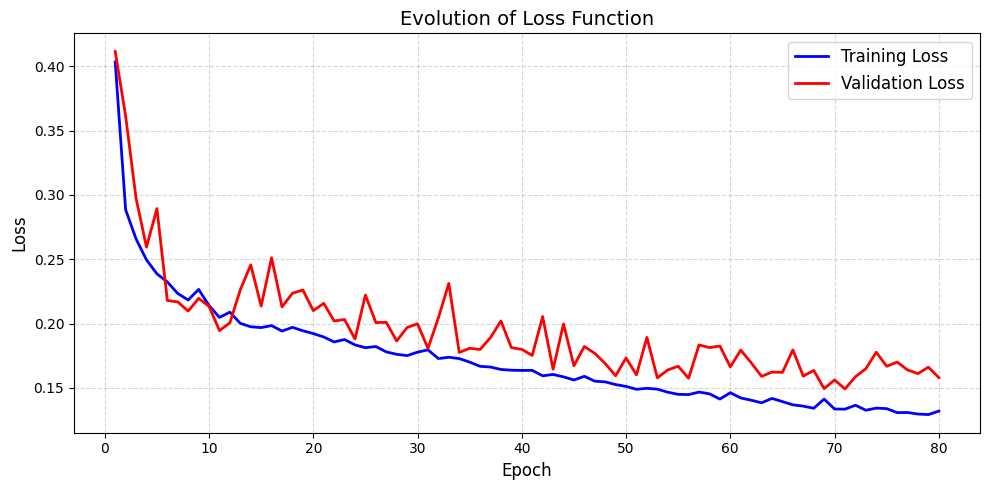

In [15]:
def combined_loss(y_true, y_pred):
    """
    Custom loss function that combines:
    - Mean Squared Error (MSE)
    - Structural Similarity Index (SSIM)
    - Mean Absolute Error (MAE)

    The weights are adjusted to prioritize perceptual similarity (SSIM),
    while still penalizing absolute and squared differences.

    Returns:
        Weighted sum: 0.2 * MSE + 0.7 * SSIM + 0.1 * MAE
    """
    mse = K.mean(K.square(y_true - y_pred))
    mae = K.mean(K.abs(y_true - y_pred))
    ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

    return 0.2 * mse + 0.7 * ssim + 0.1 * mae

# Build the U-Net model for magnitude prediction
model_magnitude = build_unet(input_shape=(288, 72, 1), mode='magnitude')

# Compile with Adam optimizer, custom loss, and standard metrics
model_magnitude.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=['mse'],
    metrics=['mae', 'mse']
    )
#model_mp.summary()

# Train the model on magnitude data with 80 epochs and small batch size
history_magnitude = model_magnitude.fit(
    X_trainm, y_trainm,
    validation_data=(X_valm, y_valm),
    epochs=80,
    batch_size=4
)


# === Plot Training and Validation Loss ===

# Extract training and validation loss from the training history
loss_m = history_magnitude.history['loss']
val_loss_m = history_magnitude.history['val_loss']
epochs_m = range(1, len(loss_m) + 1)


plt.figure(figsize=(10, 5))
plt.plot(epochs_m, loss_m, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_m, val_loss_m, 'r-', label='Validation Loss', linewidth=2)

plt.title('Evolution of Loss Function', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 490ms/step
Visualizing sample 24 (original index: 46)


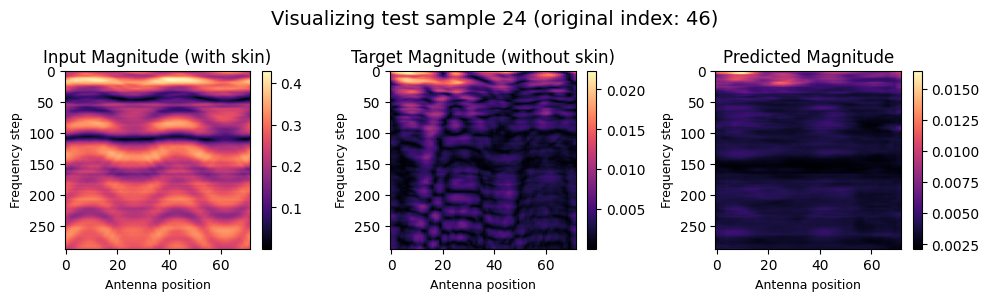

Magnitude:
MSE: 0.0000148551
MAE: 0.0026608285
SSIM: 0.3848905295
Correlation: 0.7627393587


In [17]:
# Predict the output on the test set using the trained model
y_pred_ = model_magnitude.predict(X_testm)

# Denormalize the input magnitude data (X_test) to the original scale
input_mag_denorm_ = denormalize(
    X_testm,  # Magnitude of the input
    normalization_info_['percentiles_ws_mag'],  # Normalization info
    indices_testm  # Indices for test set
)

target_magnitude = y_testm / 100
predicted_magnitude = (y_pred_ / 100)

# Select an index to visualize the prediction
idx = 24
print(f"Visualizing sample {idx} (original index: {indices_testm[idx]})")

# Create the plots to visualize the magnitude input, target, and predicted data
plt.figure(figsize=(10, 5))
plt.suptitle(f"Visualizing test sample {idx} (original index: {indices_testm[idx]})", fontsize=14)

# Visualize input magnitude (with surface)
plt.subplot(2, 3, 1)
plt.title("Input Magnitude (with skin)")
plt.xlabel('Antenna position', fontsize=9)
plt.ylabel('Frequency step', fontsize=9)
im1 = plt.imshow(input_mag_denorm_[idx], cmap='magma', aspect='auto')
plt.colorbar(im1)

# Visualize the target magnitude (without surface)
plt.subplot(2, 3, 2)
plt.title("Target Magnitude (without skin)")
plt.xlabel('Antenna position', fontsize=9)
plt.ylabel('Frequency step', fontsize=9)
im2 = plt.imshow(target_magnitude[idx], cmap='magma', aspect='auto')  # Scaling by 100 for better visualization
plt.colorbar(im2)

# Visualize predicted magnitude from the U-Net model
plt.subplot(2, 3, 3)
plt.title("Predicted Magnitude")
plt.xlabel('Antenna position', fontsize=9)
plt.ylabel('Frequency step', fontsize=9)
im3 = plt.imshow(predicted_magnitude[idx], cmap='magma', aspect='auto')  # Scaling by 100 for consistency
plt.colorbar(im3)

plt.tight_layout()  # Adjust layout for better presentation
plt.show()  # Display the plot



def calculate_metrics(true_data, pred_data):
    """Calculates error metrics between true and predicted data"""
    
    # Ensure the data is in numpy array format
    if isinstance(true_data, tf.Tensor):
        true_data = true_data.numpy()
    if isinstance(pred_data, tf.Tensor):
        pred_data = pred_data.numpy()
    
    # Basic metrics: MSE and MAE
    mse = np.mean((true_data - pred_data) ** 2)
    mae = np.mean(np.abs(true_data - pred_data))
    
    # SSIM calculation using scikit-image (recommended for image data)
    try:
        if len(true_data.shape) == 4:  # For batch data (batch, height, width, channels)
            ssim_values = []
            for i in range(true_data.shape[0]):
                img1 = true_data[i, :, :, 0] if true_data.shape[-1] == 1 else true_data[i]
                img2 = pred_data[i, :, :, 0] if pred_data.shape[-1] == 1 else pred_data[i]
                ssim_val = ssim_skimage(img1, img2, data_range=img1.max() - img1.min())
                ssim_values.append(ssim_val)
            ssim = np.mean(ssim_values)
            
        elif len(true_data.shape) == 3:  # For single image data (height, width, channels)
            img1 = true_data[:, :, 0] if true_data.shape[-1] == 1 else true_data
            img2 = pred_data[:, :, 0] if pred_data.shape[-1] == 1 else pred_data
            ssim = ssim_skimage(img1, img2, data_range=img1.max() - img1.min())
            
        else:  # 2D case (single image)
            ssim = ssim_skimage(true_data, pred_data, data_range=true_data.max() - true_data.min())
            
    except Exception as e:
        print(f"Error calculating SSIM with scikit-image: {e}")
        ssim = np.nan  # Return NaN if SSIM calculation fails
    
    # Correlation metric
    try:
        correlation = np.corrcoef(true_data.flatten(), pred_data.flatten())[0, 1]
    except:
        correlation = np.nan  # Return NaN if correlation calculation fails
    
    return {
        'MSE': mse,  # Mean Squared Error
        'MAE': mae,  # Mean Absolute Error
        'SSIM': ssim,  # Structural Similarity Index
        'Correlation': correlation  # Pearson Correlation Coefficient
    }



# Evaluate the model's metrics on the test set
print("Magnitude:")

# Calculate metrics for the predicted magnitude vs. actual magnitude
mag_metrics_ = calculate_metrics(y_testm/100, y_pred_/100)

# Print out the calculated metrics
for metric, value in mag_metrics_.items():
    print(f"{metric}: {value:.10f}")


In [87]:
id = 7
id1 = 24
id2 = 41
print(np.max(target_magnitude[id]), np.max(predicted_magnitude[id]), (np.max(target_magnitude[id])-np.max(predicted_magnitude[id]))*100/np.max(target_magnitude[id]))
print(np.max(target_magnitude[id1]), np.max(predicted_magnitude[id1]), (np.max(target_magnitude[id1])-np.max(predicted_magnitude[id1]))*100/np.max(target_magnitude[id1]))
print(np.max(target_magnitude[id2]), np.max(predicted_magnitude[id2]), (np.max(target_magnitude[id2])-np.max(predicted_magnitude[id2]))*100/np.max(target_magnitude[id2]))

print('min--:')
print(np.min(target_magnitude[id]), np.min(predicted_magnitude[id]), (np.min(target_magnitude[id])-np.min(predicted_magnitude[id]))*100/np.min(target_magnitude[id]))
print(np.min(target_magnitude[id1]), np.min(predicted_magnitude[id1]), (np.min(target_magnitude[id1])-np.min(predicted_magnitude[id1]))*100/np.min(target_magnitude[id1]))
print(np.min(target_magnitude[id2]), np.min(predicted_magnitude[id2]), (np.min(target_magnitude[id2])-np.min(predicted_magnitude[id2]))*100/np.min(target_magnitude[id2]))

0.035830957842613004 0.03362191 6.16519070696915
0.022368261967811883 0.022700686 -1.4861415715024764
0.031601176696666414 0.025335088 19.828655067445286
min--:
3.304332626509153e-05 0.00054887845 -1561.0871660010428
7.383626914037606e-06 0.00038332597 -5091.567414386265
0.0001017491986361192 0.00086363225 -748.7853044853001


### Save one specific predicted sample to reconstruct with DAS. (and save model)

In [81]:
idx = 41
s11 = predicted_magnitude[idx] * np.exp(1j * predicted_phase[idx])
np.save(f'sample_{idx}.npy', s11)

In [16]:
model_magnitude.save('magnitude_skinsubstraction.keras')
model_phase.save('phase_skinsubstraction.keras')